# Lab 6: MNIST with CNN Model

## Objective:
You need to create your own Jupyter Notebook.

The goal of this assignment is to build, train, and evaluate a Convolutional Neural Network (CNN) for handwritten digit recognition using the MNIST dataset. You will also preprocess data, visualize results, and upload your work to GitHub for review.

## 1. Instuctions
### 1.1. Download the MNIST dataset using PyTorch's torchvision.datasets module. 
- Hint: from torchvision.datasets import MNIST
   
### 1.2. Save the dataset in a format that can be accessed throughout your notebook.


In [211]:
import torch
import torchvision
from torch import nn, optim
from torchvision import transforms, models, datasets
from torchsummary import summary
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

In [213]:
# transformer pipeline to condition images
transform = transforms.Compose([
    transforms.RandomRotation(degrees=20), #random rotation to avoid overfitting for common rotation
    transforms.ToTensor(), # convert the images to tensors which limit their pixel values from 0-255 to 0-1
    transforms.Normalize((0.5,), (0.5,)) # normalize tensors with mean 0.5 and std dev 0.5 which changes the range from 0-1 to -1-1
])

# download the training set of data from the MNIST dataset (used for handwriting recognition models)
train_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=True,
    transform=transform,
    download=True
)

# download the testing set
test_dataset = torchvision.datasets.MNIST(
    root="./data",
    train=False,
    transform=transform,
    download=True
)

## 2. Prepare the Data

### 2.1 Introduce the MNIST Dataset
- Write a brief explanation about the MNIST dataset in your Jupyter Notebook.
- Include details such as:
  - The size of the dataset.
  - Number of classes (digits 0-9).
  - Image dimensions.

### 2.2 Create a Dataset and DataLoader
- Create a PyTorch Dataset to handle the raw MNIST data.
- Use a PyTorch DataLoader to manage batching for your data.

### 2.3 Preprocess the Data
- Apply necessary transforms (e.g., normalization, resizing) to preprocess the data.
- Use PyTorch’s torchvision.transforms or other preprocessing methods.
- Clearly explain why the preprocessing steps were necessary.

### 2.4 Visualize the Processed Data
- Visualize a sample of the processed data (e.g., show a grid of images).
- Use appropriate titles for the visualizations to include your name.


## MNIST Dataset Explanation
The MNIST dataset is a set of 70,000 hand-drawn single digit numbers. 
The set is split between 60,000 training images and 10,000 test images.
Each image is greyscale with color values ranging from 0-255
Each image is 1 channel x 28 pixels wide * 28 pixels tall, equating to 784 attributes per image
An image can represent one of 10 classes coresponding to digits 0-9.

## Preprocessor Steps Explanation
- Random rotation: Applying a rotation to the numbers makes the model more generalized, allowing for numbers of different orientations to be classified correctly.
- Tensorization: Each image is converted to a tensor with a value scaled from 0 to 1. This makes the model more reliable and efficient.
- Normalization: Normalization to the range of -1 to 1 reduces convergence time.

In [217]:
# set up a dataloader for the training dataset, shuffle between epochs to avoid overfitting
train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=64, 
    shuffle=True
)

# set up a dataloader for the testing dataset, shuffle not needed for testing
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=64, 
    shuffle=False
)

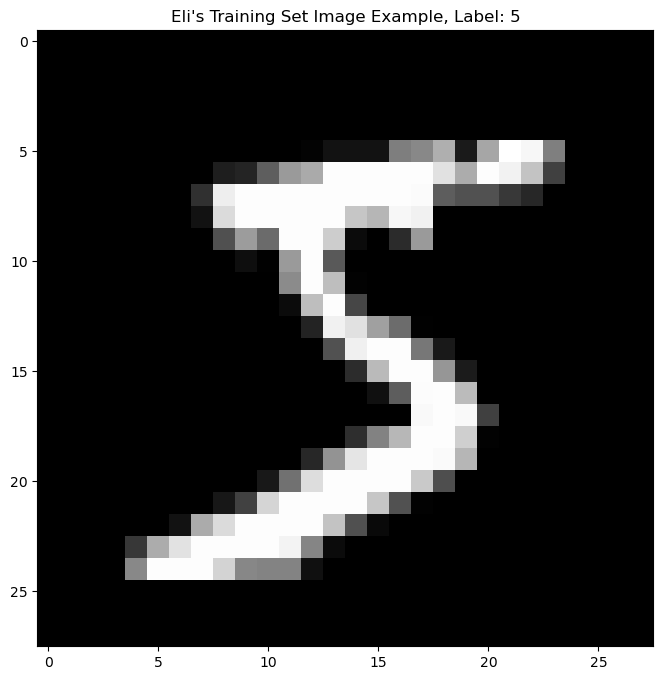

In [219]:
# show a sample image to confirm the training images were imported and transformed correctly

# get the image and its label from the training dataset
image, label = train_dataset[0]

# show the image using matplotlib pyplot
plt.figure(figsize=(8,8))
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Eli\'s Training Set Image Example, Label: {label}")
plt.show()

And for the testing set:

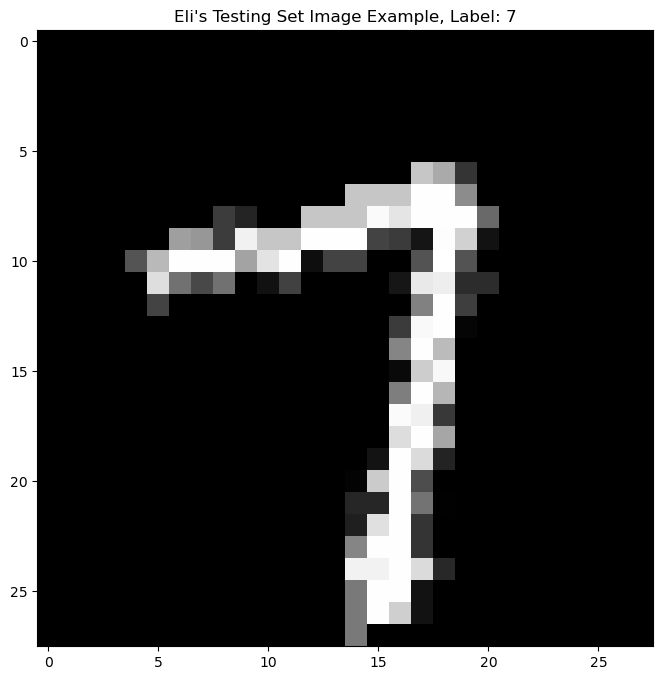

In [222]:
# get the image and its label from the training dataset
image, label = test_dataset[0]

# show the image using matplotlib pyplot
plt.figure(figsize=(8,8))
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"Eli\'s Testing Set Image Example, Label: {label}")
plt.show()

## 3. Build a CNN Model

### 3.1 Define the Model Structure
- Design your own CNN model with layers like convolutional layers, pooling layers, and fully connected layers.
- The model must be implemented using PyTorch.

### 3.2 Set Up the Trainer
- Define a training loop that includes:
  - A loss function (e.g., Cross-Entropy Loss).
  - An optimizer (e.g., Adam or SGD).
  - A learning rate scheduler (if applicable).

### 3.3 Summarize Your Model
- Use torchsummary or other tools to display a summary of your CNN, showing:
  - Layer names.
  - Output dimensions for each layer.
  - Total number of parameters.

### 3.4 Train Your Model
- Train your model for multiple epochs (e.g., 50–100).
- Ensure that your model learns effectively by monitoring loss and accuracy during training.


## Define the Model

In [234]:
class CNN(torch.nn.Module):
    def __init__(self, MODEL_SIZE=8):
        super().__init__()

        # leaky ReLU slope "constant"
        LEAKY_RELU_SLOPE = 0.01
        
        self.main = torch.nn.Sequential(
            # convolutional layer 1
            nn.Conv2d(
                in_channels=1,  # grayscale image has 1 channel
                out_channels=MODEL_SIZE,  # MODEL_SIZE filters will extract a good amount of patterns 
                kernel_size=(3, 3),  # small kernel for small images
                padding=1  # padding to keep the output image the same size
            ),
            nn.LeakyReLU(negative_slope=LEAKY_RELU_SLOPE),  # leaky ReLU activation function
            nn.MaxPool2d(
                kernel_size=2,  # standard kernel size for pooling
                stride=2  # no overlap when pooling, avoids blurring 
            ),

            # convolutional layer 2
            nn.Conv2d(
                in_channels=MODEL_SIZE,  # filters from last layer
                out_channels=MODEL_SIZE * 2,  # increase number of filters
                kernel_size=(3, 3),  # small kernel for small images
                padding=1  # padding to keep the output image the same size
            ),
            nn.LeakyReLU(negative_slope=LEAKY_RELU_SLOPE),  # activation function
            nn.MaxPool2d(
                kernel_size=2,  # standard kernel size for pooling
                stride=2  # no overlap when pooling, avoids blurring 
            ),

            # flatten the output tensor to prepare it for the fully connected network
            nn.Flatten(),

            # fully connected layer 1
            nn.Linear(
                (MODEL_SIZE * 2) * 7 * 7,  # MODEL_SIZE * 2 filters from the 2nd convolutional layer, 7 * 7 pixel image
                MODEL_SIZE * 4  # output size of MODEL_SIZE * 4
            ),
            nn.LeakyReLU(negative_slope=LEAKY_RELU_SLOPE),  # activation function

            # fully connected layer 2 (output layer)
            nn.Linear(
                MODEL_SIZE * 4,  # features from the previous layer
                10  # 10 output classes for each possible digit type (numbers 0-9)
            ) 
        )

    def forward(self, x):
        out = self.main(x)
        return out


## Define the Trainer

In [237]:
def trainer(model, criterion, optimizer, trainloader, validloader, epochs=5, verbose=True):
    """
    Train and validate a PyTorch model.
    
    Args:
        model: PyTorch model to train.
        criterion: Loss function.
        optimizer: Optimizer for updating weights.
        trainloader: DataLoader for training data.
        validloader: DataLoader for validation data.
        epochs: Number of epochs for training.
        verbose: If True, print progress for each epoch.
    
    Returns:
        A dictionary containing training loss, validation loss, and validation accuracy.
    """
    
    train_loss, valid_loss, valid_accuracy = [], [], []

    # list to track number of misidentifications per class during validation
    class_misclassifications = [0] * 10  

    # lists to store true and predicted labels for confusion matrix
    all_true_labels = []
    all_pred_labels = []
    
    for epoch in range(epochs):  # for each epoch
        train_batch_loss = 0
        valid_batch_loss = 0
        correct = 0
        total = 0
        
        # Training
        model.train()
        for X, y in trainloader:
            optimizer.zero_grad()  # Reset gradients
            y_hat = model(X)  # Forward pass: compute the model's prediction
            loss = criterion(y_hat, y.type(torch.long))  # Compute loss
            loss.backward()  # Backpropagation: compute gradients
            optimizer.step()  # Update model parameters using optimizer
            train_batch_loss += loss.item() * X.size(0)  # Accumulate batch loss
        train_loss.append(train_batch_loss / len(trainloader.dataset))  # Compute average training loss for this epoch
        
        # Validation
        model.eval()  # Set the model to evaluation mode
        valid_batch_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():  # Save memory during validation
            for X, y in validloader:
                y_hat = model(X)  # Forward pass
                loss = criterion(y_hat, y.type(torch.long))  # Compute loss
                valid_batch_loss += loss.item() * X.size(0)  # Accumulate validation loss (weighted by batch size)

                # For multi-class classification
                _, predicted = torch.max(y_hat, 1)
                correct += (predicted == y).sum().item()
                total += y.size(0)

                # Store true & predicted labels for confusion matrix
                all_true_labels.extend(y.cpu().numpy())  
                all_pred_labels.extend(predicted.cpu().numpy())

                for true_label, predicted_label in zip(y, predicted):
                    if true_label != predicted_label:
                        class_misclassifications[true_label.item()] += 1

        valid_loss.append(valid_batch_loss / len(validloader.dataset))  # Compute average validation loss
        valid_accuracy.append(correct / total * 100)  # Compute overall accuracy

        # Print progress
        if verbose:
            print(f"Epoch {epoch + 1}:",
                  f"Train Loss: {train_loss[-1]:.3f}.",
                  f"Valid Loss: {valid_loss[-1]:.3f}.",
                  f"Valid Accuracy: {valid_accuracy[-1]:.2f}%")
            
            print("Misclassifications per digit:")
            for digit, count in enumerate(class_misclassifications):
                print(f"  {digit}: {count}")
    
    results = {
        "train_loss": train_loss,
        "valid_loss": valid_loss,
        "valid_accuracy": valid_accuracy,
        "class_misclassifications": class_misclassifications,  # Misclassification counts per class
        "true_labels": all_true_labels,  # True labels for confusion matrix
        "predicted_labels": all_pred_labels  # Predicted labels for confusion matrix
    }
    
    return results


## Show Model Summary

In [246]:
model = CNN(MODEL_SIZE=4)
summary(model, (1, 28, 28));  # (1, 28, 28) is the shape of MNIST images (grayscale, 28x28)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 10]                  --
|    └─Conv2d: 2-1                       [-1, 4, 28, 28]           40
|    └─LeakyReLU: 2-2                    [-1, 4, 28, 28]           --
|    └─MaxPool2d: 2-3                    [-1, 4, 14, 14]           --
|    └─Conv2d: 2-4                       [-1, 8, 14, 14]           296
|    └─LeakyReLU: 2-5                    [-1, 8, 14, 14]           --
|    └─MaxPool2d: 2-6                    [-1, 8, 7, 7]             --
|    └─Flatten: 2-7                      [-1, 392]                 --
|    └─Linear: 2-8                       [-1, 16]                  6,288
|    └─LeakyReLU: 2-9                    [-1, 16]                  --
|    └─Linear: 2-10                      [-1, 10]                  170
Total params: 6,794
Trainable params: 6,794
Non-trainable params: 0
Total mult-adds (M): 0.10
Input size (MB): 0.00
Forward/backward pass size (MB): 0

## Train the Model

In [248]:
VERBOSE = True

criterion = nn.CrossEntropyLoss() # cross entropy loss for multiple class classification model
optimizer = optim.Adam(model.parameters(), lr=0.001)

results = trainer(model, criterion, optimizer, train_loader, test_loader, epochs=15, verbose=VERBOSE)

print("Training completed.")

if VERBOSE:
    print(f"Final Train Loss: {results['train_loss'][-1]:.3f}")
    print(f"Final Validation Loss: {results['valid_loss'][-1]:.3f}")
    print(f"Final Validation Accuracy: {results['valid_accuracy'][-1]:.2f}%")
    
    print("\nFinal Misclassifications per digit:")
    for digit, count in enumerate(results["class_misclassifications"]):
        print(f"  {digit}: {count}")

Epoch 1: Train Loss: 0.529. Valid Loss: 0.205. Valid Accuracy: 93.45%
Misclassifications per digit:
  0: 29
  1: 25
  2: 46
  3: 34
  4: 76
  5: 73
  6: 60
  7: 81
  8: 173
  9: 58
Epoch 2: Train Loss: 0.177. Valid Loss: 0.141. Valid Accuracy: 95.45%
Misclassifications per digit:
  0: 40
  1: 32
  2: 118
  3: 57
  4: 123
  5: 144
  6: 77
  7: 121
  8: 270
  9: 128
Epoch 3: Train Loss: 0.141. Valid Loss: 0.111. Valid Accuracy: 96.54%
Misclassifications per digit:
  0: 56
  1: 52
  2: 153
  3: 90
  4: 148
  5: 166
  6: 98
  7: 164
  8: 335
  9: 194
Epoch 4: Train Loss: 0.123. Valid Loss: 0.109. Valid Accuracy: 96.48%
Misclassifications per digit:
  0: 84
  1: 60
  2: 215
  3: 132
  4: 179
  5: 180
  6: 134
  7: 186
  8: 395
  9: 243
Epoch 5: Train Loss: 0.111. Valid Loss: 0.104. Valid Accuracy: 96.59%
Misclassifications per digit:
  0: 94
  1: 67
  2: 254
  3: 155
  4: 222
  5: 200
  6: 192
  7: 227
  8: 443
  9: 295
Epoch 6: Train Loss: 0.103. Valid Loss: 0.087. Valid Accuracy: 97.21%
M

## 4. Visualize and Evaluate

- Create at least 5 visualizations to evaluate/visualize the performance of your model, such as (you can make your own choice):
  - Training loss over epochs.
  - Validation loss over epochs.
  - Visualize predicted results and actual results.
  - Validation accuracy over epochs.
  - Confusion matrix or misclassified examples.

- **Requirement**: Add your name to the title of each visualization.

- Use text cells to explain your visualizations and analyze the quality of your model. 

  For example:
  - How well does your model perform on the test set?
  - Are there patterns in the loss/accuracy curves (e.g., overfitting or underfitting)?
  - Which digits are most often misclassified?


### Plot 1: Training Loss Over Epoch
Training loss over time shows the progress between training epochs as the average loss over time drops. Loss shows the difference between the predicted and true values for the given input. From the graph we can see that training loss drops drastically between the first and second epochs and begins to plateau around the sixth epoch.

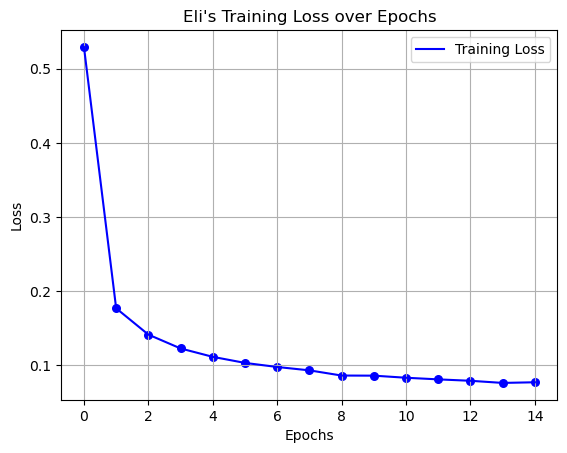

In [257]:
# plot 1, training loss over epochs
plt.plot(results['train_loss'], label='Training Loss', color='blue')
plt.scatter(range(len(results['train_loss'])), results['train_loss'], color='blue', s=30)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Eli's Training Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

### Plot 2: Validation Loss Over Epoch 
Similar to training loss, but this loss is calculated on data that the model is not trained on, thus the name validation (evaluation step) loss. Validation loss is a lot less consistent than training loss becuase it's testing the models predictions on information it has never seen before, so this is to be expected.

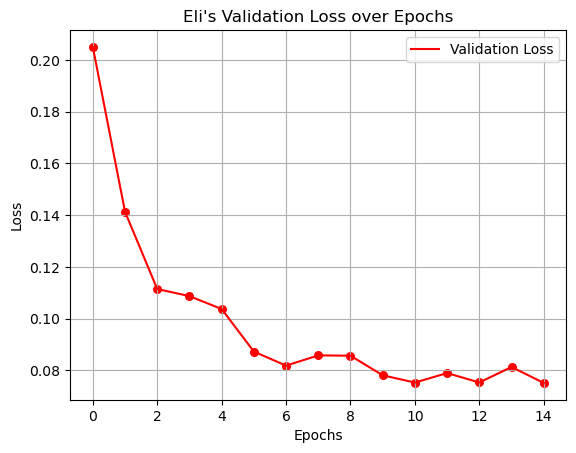

In [259]:
# plot 2, validation loss over epochs
plt.plot(results['valid_loss'], label='Validation Loss', color='red')
plt.scatter(range(len(results['valid_loss'])), results['valid_loss'], color='red', s=30)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title("Eli's Validation Loss over Epochs")
plt.legend()
plt.grid()
plt.show()

### Plot 3: Validation Accuracy Over Epoch 
Shape similar to validation loss but flipped vertically, validation accuracy measures the accuracy of the models predictions in percent over epoch. This model made the most progress between the first and second, second and thrid, and fourth and fith epochs.

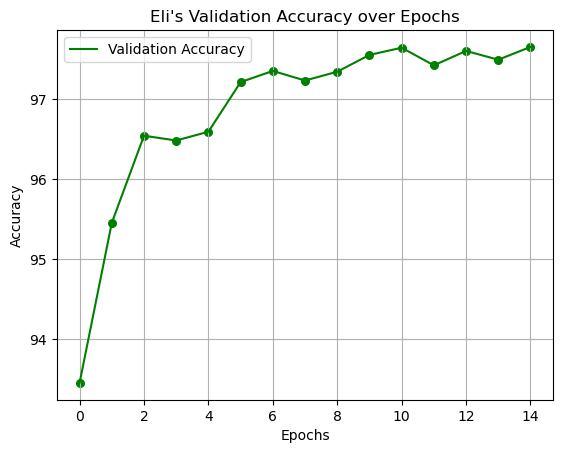

In [261]:
# plot 3, validation accuracy over epochs
plt.plot(results['valid_accuracy'], label='Validation Accuracy', color='green')
plt.scatter(range(len(results['valid_accuracy'])), results['valid_accuracy'], color='green', s=30)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Eli's Validation Accuracy over Epochs")
plt.legend()
plt.grid()
plt.show()

### Plot 4: Most Misclassified Digits
This bar graph shows the number of times the model misidentified each of the 10 digits we train in. It looks like 8 is the hardest to identify and 1 is the easiest. Intuitivlty this makes sense as 8 shares common features with numbers 3, 6, and 9 in its curves and circles.

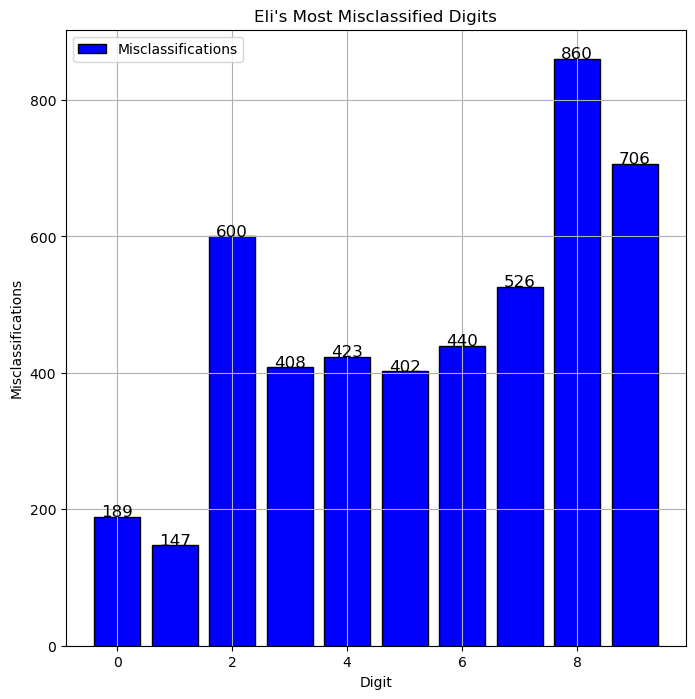

In [263]:
# plot 4, display bar graph showing number of times each number was mis-classified
plt.figure(figsize=(8, 8))  # Set figure size

plt.bar(range(10), results["class_misclassifications"], color='blue', edgecolor='black', label="Misclassifications")

# Add numbers on top of bars
for i, count in enumerate(results["class_misclassifications"]):
    plt.text(i, count + 0.5, str(count), ha='center', fontsize=12)

# Labels and title
plt.xlabel("Digit")
plt.ylabel("Misclassifications")
plt.title("Eli's Most Misclassified Digits")
plt.legend()
plt.grid()

plt.show()

### Plot 5: Confusion Matrix
This confusion matrix shows the number of times the model correctly and incorrectly identifies each digit and the number of times it incorrectly classifies 

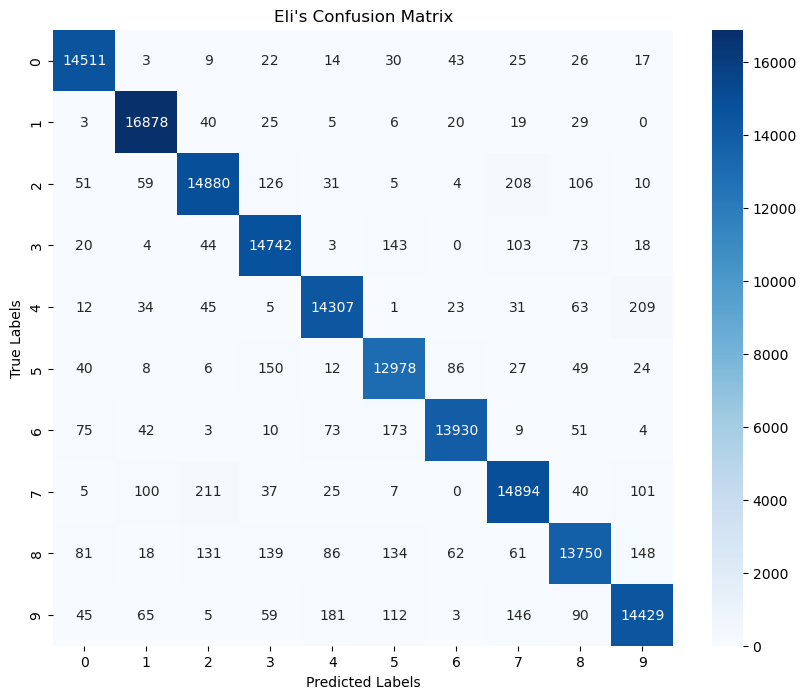

In [267]:
# plot 5, show the confusion matrix of the model

# Get the true and predicted labels
true_labels = results["true_labels"]
predicted_labels = results["predicted_labels"]

# Compute the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[str(i) for i in range(10)], yticklabels=[str(i) for i in range(10)])
plt.title("Eli's Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

## 5. Save and Upload Your Work

- Save your trained model to a file (e.g., .pt or .pth format).
  - **Hint**: Use torch.save to save your model weights.

- Upload the following to GitHub:
  - Your saved model file.
  - Your Jupyter Notebook with well-commented code and explanations.

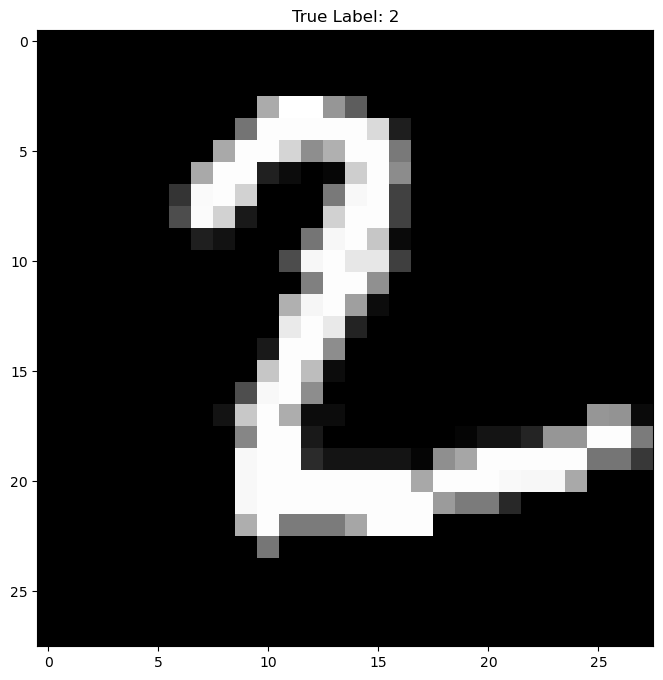


True Label: 2
Predicted Label: 2


In [273]:
MODEL_PATH = "model_weights.pth"

# save the model to a file and read it do validate it
torch.save(model.state_dict(), MODEL_PATH)

# initialize new model to load to
model_loaded = CNN(MODEL_SIZE=4)

# load the weights from file
model_loaded.load_state_dict(torch.load(MODEL_PATH))
model_loaded.eval()

# test the model with a random number from the test dataset

# Select an image from the test dataset
image, true_label = test_dataset[1]  # Get the first image in the test set

# Show the image using pyplot
plt.figure(figsize=(8,8))
plt.imshow(image.squeeze(), cmap='gray')
plt.title(f"True Label: {true_label}")
plt.show()

# Prepare the image (need to add a batch dimension and move it to the same device as the model)
image = image.unsqueeze(0)  # Add batch dimension (1, 1, 28, 28)

# Make a prediction
with torch.no_grad():  # No need to track gradients during inference
    output = model_loaded(image)
    _, predicted_label = torch.max(output, 1)  # Get the index of the maximum output (predicted class)

# Print the true and predicted labels
print(f"\nTrue Label: {true_label}")
print(f"Predicted Label: {predicted_label.item()}")

### Coding Requirements

- **Code Comments**: Add necessary comments to explain your code.
- **Text Explanations**: Use Markdown cells in your notebook to explain each step in detail.
- **Code Quality**: Ensure your code is clean, modular, and easy to read.

### Submission:

- A complete Jupyter Notebook that includes:
  - Data preparation.
  - CNN model creation and training.
  - Visualizations with explanations and your name in the titles.
  - A saved model file.
  - All files uploaded to your GitHub repository.
  
- Submit your GitHub link to Canvas.
